In [9]:
#import scipy.stats as ss
import matplotlib.pyplot as plt

import cupy as cp
import cupy.random as cr

from tqdm import tqdm
import time

import numpy
import scipy.stats as ss

In [ ]:


def scalar_particle_gen(vp,nParticles):

    # Generate particles with maxwell distribution              
    # vp is the most probable speed of the maxwell distribution 

    
    velocity_vec = (vp/cp.sqrt(2))*cr.normal( size = (3,1,nParticles) )
    
    phase_vec = cr.uniform(  size = (1,1,nParticles) )*2*cp.pi
        
    return velocity_vec , phase_vec



# it sums up the GRADIENT of the scalar field!
def scalar_grad_random_walk(tX,omega,K,phase):
    
    # tX[4,nPoints]: the time-space coordinates
    # omega[1,1,nParticles]
    # K[3,1,nParticles]
    
    nParticles = omega.shape[2]
    nPoints = tX.shape[1]
    
    phase_tensor = cp.tile(phase,(1,nPoints,1))
    
    # tot[nPoints, nParticles]
    tot = cp.exp(1j*(cp.outer(tX[0,:],omega[0,0,:])\
                              - cp.matmul(tX[1:,:].transpose(),K[:,0,:])\
                              + phase_tensor[:,0,:] )) # scalar field
    # Sca[nPoints]
    # gradSca[3,nPoints]
    sca = cp.sum(cp.real(tot),axis=1)
    
    gradsca = cp.sum(cp.tile(cp.imag(tot),(3,1,1))*cp.tile(K,(1,nPoints,1)), axis=2)

    
    return sca, gradsca




## Statistics.

In [ ]:
'''
Get the marginal distribution
'''
vp=1e-3
log10m = -22.
m=10**log10m

t_corr = 2*cp.pi/m
l_dB = 2*cp.pi/m/vp
#ev2kpc = 3.0857e19 /1.973e-7


nPoints = 16

tx = cp.zeros((4,nPoints)) # look at the same space points
tlist= cp.linspace(0,1,nPoints+1)
tx[0,:] = tlist[:-1]*t_corr

nParticles = 2**14 # gpu is generally faster than cpu when n is large

nSimulation= 100000

gradsca0sq = cp.ndarray((3,nSimulation))
gradphases = cp.ndarray((3,nSimulation))


sca0sq = cp.ndarray((1,nSimulation))
phases = cp.ndarray((1,nSimulation))


'''
Main:
'''
for i in tqdm(range(nSimulation)):
    
    v,p = scalar_particle_gen(vp,nParticles)
    
    # Physical values   
    m = 10**log10m # eV
    K = m*v

    # From K to omega
    omega = cp.ndarray((1,nPoints,nParticles))
    omega[0,:,:] = cp.sqrt(cp.sum(K*K,axis=0)+m**2)
    
    #Retx(3,nPoints)
    sca, gradsca = scalar_grad_random_walk(tx,omega,K,p)
    #results(3,nSimulation)
    
    sca0sq[0,i] = 2 * cp.sum(sca*sca, axis=0)/nPoints #  mean value over time
    phases[0,i] = tlist[cp.where(cp.max(sca) == sca)[0][0]]*2*cp.pi

    gradsca0sq[:,i] = 2 * cp.sum(gradsca*gradsca,axis=1)/nPoints
    gradphases[0,i] = tlist[cp.where(cp.max(gradsca[0,:]) == gradsca[0,:])[0][0]]*2*cp.pi
    gradphases[1,i] = tlist[cp.where(cp.max(gradsca[1,:]) == gradsca[1,:])[0][0]]*2*cp.pi
    gradphases[2,i] = tlist[cp.where(cp.max(gradsca[2,:]) == gradsca[2,:])[0][0]]*2*cp.pi

In [ ]:
# Data processing
# Fit with gamma functions
mean = cp.mean(sca0sq)
normfac = mean*m**2*(vp/cp.sqrt(2))**2
y = gradsca0sq[0,:]/normfac
y = cp.asnumpy(y)


plt.figure(figsize=(6,4))
# Histogram
Pr,bins,fig=plt.hist(y,30,density=True,label="Simulation",color="steelblue");
midbins = numpy.diff(bins)/2.+bins[:-1]

# curve fit
a,loc,scale = ss.gamma.fit(y,floc=0)
Pr_fit = ss.gamma.pdf(x=midbins,a=a,loc=loc,scale=scale)

plt.plot(midbins,Pr_fit,'black',linewidth=6,alpha=0.6,label='Gamma Fit')
plt.annotate(s=r"$\alpha$ = %.3f"%(a) + "\n" + r"$\beta$ = %.3f"%(1/scale),
             horizontalalignment="right",
         bbox=dict(boxstyle="round",fc="w"),xy=(0.98,0.5),xycoords='axes fraction',size=10)
plt.xlabel(r"Normalized $P_k$")
plt.ylabel("$Probability$")
plt.legend()
plt.savefig('GammaFit_scalar.pdf')


## Check the space coherence


In [ ]:

vp=1e-3
log10m = -22
m=10**log10m

t_corr = 2*cp.pi/m
l_dB = 2*cp.pi/m/vp
#ev2kpc = 3.0857e19 /1.973e-7


nPoints = 16

tx = cp.zeros((4,nPoints))
tlist= cp.linspace(0,1,nPoints+1)
tx[0,:] = tlist[:-1]*t_corr

ty = cp.zeros((4,nPoints))
ty[0,:] = tlist[:-1]*t_corr
ty[1,:] = cp.tile(l_dB,nPoints)*5.12

nParticles = 2**10
output=[]

nSimulation= 100000

gradsca0sq_A = cp.ndarray((3,nSimulation))
gradphases_A = cp.ndarray((3,nSimulation))


sca0sq_A = cp.ndarray((1,nSimulation))
phases_A = cp.ndarray((1,nSimulation))


gradsca0sq_B = cp.ndarray((3,nSimulation))
gradphases_B = cp.ndarray((3,nSimulation))


sca0sq_B = cp.ndarray((1,nSimulation))
phases_B = cp.ndarray((1,nSimulation))

'''
Main:
'''
for i in tqdm(range(nSimulation)):
    cr.seed()
    v,p = scalar_particle_gen(vp,nParticles)
    
    # Physical values   
    m = 10**log10m # eV
    K = m*v

    # From K to omega
    omega = cp.ndarray((1,nPoints,nParticles))
    omega[0,:,:] = cp.sqrt(cp.sum(K*K,axis=0)+m**2)
    
    #Retx(3,nPoints)
    sca_A, gradsca_A = scalar_grad_random_walk(tx,omega,K,p)
    sca_B, gradsca_B = scalar_grad_random_walk(ty,omega,K,p)
    #results(3,nSimulation)
    
    gradsca0sq_A[:,i] = 2 * cp.sum(gradsca_A*gradsca_A,axis=1)/nPoints
    gradphases_A[0,i] = tlist[cp.where(cp.max(gradsca_A[0,:]) == gradsca_A[0,:])[0][0]]*2*cp.pi
    gradphases_A[1,i] = tlist[cp.where(cp.max(gradsca_A[1,:]) == gradsca_A[1,:])[0][0]]*2*cp.pi
    gradphases_A[2,i] = tlist[cp.where(cp.max(gradsca_A[2,:]) == gradsca_A[2,:])[0][0]]*2*cp.pi
    

    gradsca0sq_B[:,i] = 2 * cp.sum(gradsca_B*gradsca_B,axis=1)/nPoints
    gradphases_B[0,i] = tlist[cp.where(cp.max(gradsca_B[0,:]) == gradsca_B[0,:])[0][0]]*2*cp.pi
    gradphases_B[1,i] = tlist[cp.where(cp.max(gradsca_B[1,:]) == gradsca_B[1,:])[0][0]]*2*cp.pi
    gradphases_B[2,i] = tlist[cp.where(cp.max(gradsca_B[2,:]) == gradsca_B[2,:])[0][0]]*2*cp.pi


In [ ]:
'''
Calculate the correlation !!!
'''

a = gradsca0sq_A[0,:]
b = gradsca0sq_B[0,:]
c = gradsca0sq_B[1,:]
d = gradphases_A[0,:]
e = gradphases_B[0,:]
f = gradphases_B[1,:]

results = cp.ndarray((6))

i = 0
for (x2,y2) in [(a,b),(a,c),(d,e),(d,f),(a,e),(a,f)]:

    x = cp.sqrt(x2)
    y = cp.sqrt(y2)

    m_x2 = cp.mean(x2)
    m_x = cp.mean(x)
    m_y2 = cp.mean(y2)
    m_y = cp.mean(y)

    sig_x = cp.sqrt(m_x2-m_x**2)
    sig_y = cp.sqrt(m_y2-m_y**2)
    
    res = cp.mean((x-m_x)*(y-m_y))/sig_x/sig_y
    
    results[i] = res    
    i = i+1
    
print(results)

In [10]:
kpc2nat = 3.0857e19 /1.973e-7

l = 0.5*kpc2nat/(2*cp.pi/10**(-21.5)/vp)
print("%.3f"%(l))

3.936


In [11]:
corr = cp.ndarray((10,6))
Dis = cp.array([0.01,0.02,0.04,0.08,0.16,0.32,0.64,1.28,2.56,5.12])

corr[0,:] = cp.array([ 0.99316287,  0.00117047,  0.91154787, -0.00267821, -0.00357969, -0.00398685])
corr[1,:] = cp.array([0.97310057, 0.0093235,  0.83362105, 0.00551441, 0.00122878, 0.00097771])
corr[2,:] = cp.array( [0.89822661,  0.00471952,  0.70233971,  0.00227854, -0.00113134, -0.00183281])
corr[3,:] = cp.array([ 6.49196339e-01, -5.28519157e-03,  4.83056917e-01, -4.95053350e-04,
 -5.72322080e-03, -1.49602049e-03])
corr[4,:] = cp.array([ 0.14317936,  0.00102512,  0.16944174,  0.00439917, -0.00069113,  0.002165  ])
corr[5,:] = cp.array([ 0.13554992, -0.00016264, -0.14422169, -0.0016231,  -0.00354684, -0.00425794])
corr[6,:] = cp.array([ 0.01642035,  0.00279873, -0.04770202,  0.00197334,  0.00309777, -0.0019922 ])
corr[7,:] = cp.array([ 0.00186574,  0.00687037,  0.00254376,  0.00146656, -0.0046811,  -0.00099712])
corr[8,:] = cp.array([-0.00018365, -0.00633236,  0.00148117,  0.00593821, -0.00456514,  0.00528074])
corr[9,:] = cp.array([ 0.00477004,  0.00203235, -0.00483423,  0.0071575,  -0.00036734, -0.00114853])




perc235=cp.array([0.039,0.118])
perc23=cp.array([0.124,0.373])
perc225=cp.array([0.393,1.181])
perc22=cp.array([1.245,3.734])




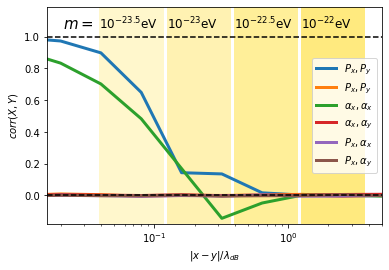

In [18]:
corr = cp.asnumpy(corr)
Dis = cp.asnumpy(Dis)
perc235 = cp.asnumpy(perc235)
perc23 = cp.asnumpy(perc23)
perc225 = cp.asnumpy(perc225)
perc22 = cp.asnumpy(perc22)

plt.figure(figsize=(6,4))
ll = -0.18
hl = 1.19
lel = 10**-1.8
ril = 10**0.7
plt.ylim([ll,hl])
plt.xlim([lel,ril])

plt.semilogx(Dis,corr[:,0],label="$P_{x},P_{y}$",linewidth=3);
plt.semilogx(Dis,corr[:,1],label="$P_{x},P_{y}$",linewidth=3);
plt.semilogx(Dis,corr[:,2],label=r"$\alpha_{x},\alpha_{x}$",linewidth=3);
plt.semilogx(Dis,corr[:,3],label=r"$\alpha_{x},\alpha_{y}$",linewidth=3);
plt.semilogx(Dis,corr[:,4],label=r"$P_{x},\alpha_{x}$",linewidth=3);
plt.semilogx(Dis,corr[:,5],label=r"$P_{x},\alpha_{y}$",linewidth=3);

plt.plot([lel,ril],[0,0],'k--')
plt.plot([lel,ril],[1,1],'k--')

plt.fill_between(perc235,[hl,hl],[ll,ll],facecolor='gold',alpha=0.2)
plt.fill_between(perc23,[hl,hl],[ll,ll],facecolor='gold',alpha=0.3)
plt.fill_between(perc225,[hl,hl],[ll,ll],facecolor='gold',alpha=0.4)
plt.fill_between(perc22,[hl,hl],[ll,ll],facecolor='gold',alpha=0.5)


plt.annotate("$m =$",horizontalalignment="right",xy=[perc235[0]*0.9,1.05],xycoords='data',size=15)
plt.annotate("$10^{-23.5}$eV",horizontalalignment="left",xy=[perc235[0],1.05],xycoords='data',size=12)
plt.annotate("$10^{-23}$eV",horizontalalignment="left",xy=[perc23[0],1.05],xycoords='data',size=12)
plt.annotate("$10^{-22.5}$eV",horizontalalignment="left",xy=[perc225[0],1.05],xycoords='data',size=12)
plt.annotate("$10^{-22}$eV",horizontalalignment="left",xy=[perc22[0],1.05],xycoords='data',size=12)



plt.xlabel("$|x-y|/\lambda_{dB}$")
plt.ylabel("$corr(X,Y)$")
plt.legend()
plt.savefig('SpatialCorr_scalar.pdf')